In [2]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import io

In [3]:
def fetch_csv(file_id):
    url = f'https://drive.google.com/uc?id={file_id}&export=download'
    response = requests.get(url)
    if response.status_code == 200:
        return pd.read_csv(io.StringIO(response.content.decode('utf-8')))
    else:
        print(f"Error fetching the file with ID: {file_id}")
        return None

customers_id = '1bu_--mo79VdUG9oin4ybfFGRUSXAe-WE'
products_id = '1IKuDizVapw-hyktwfpoAoaGtHtTNHfd0'
transactions_id = '1saEqdbBB-vuk2hxoAf4TzDEsykdKlzbF'

customers_df = fetch_csv(customers_id)
products_df = fetch_csv(products_id)
transactions_df = fetch_csv(transactions_id)

Merged DataFrame columns: ['TransactionID', 'CustomerID', 'ProductID', 'TransactionDate', 'Quantity', 'TotalValue', 'Price', 'CustomerName_x', 'Region_x', 'SignupDate_x', 'CustomerName_y', 'Region_y', 'SignupDate_y', 'CustomerName', 'Region', 'SignupDate']

Davies-Bouldin Index: 1.554
Silhouette Score: 0.173


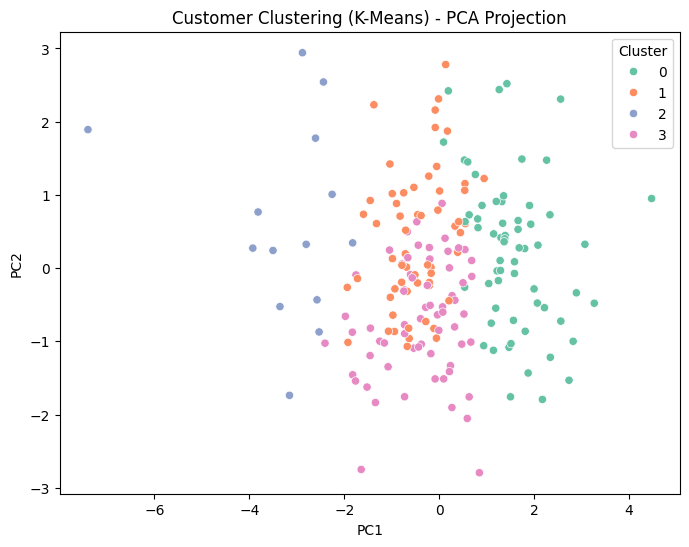


Clustering Completed Successfully!
Cluster Distribution:
Cluster
3    66
0    62
1    58
2    14
Name: count, dtype: int64


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA


transactions_clean = transactions_df.drop(
    ['Region', 'CustomerName', 'SignupDate'],
    axis=1,
    errors='ignore'
)



merged_df = pd.merge(
    transactions_clean,
    customers_df,
    on='CustomerID',
    how='left'
)
print("Merged DataFrame columns:", merged_df.columns.tolist())


customer_agg = merged_df.groupby('CustomerID', as_index=False).agg({
    'TransactionID': 'count',
    'TotalValue': 'sum',
    'TransactionDate': 'max'
})


customer_agg.rename(columns={
    'TransactionID': 'TotalTransactions',
    'TotalValue': 'TotalSpend',
    'TransactionDate': 'LastTransactionDate'
}, inplace=True)


cust_features = pd.merge(
    customers_df,
    customer_agg,
    on='CustomerID',
    how='left'
)

# Fill missing if no transactions
cust_features['TotalTransactions'] = cust_features['TotalTransactions'].fillna(0)
cust_features['TotalSpend'] = cust_features['TotalSpend'].fillna(0)

# Calculate average spend
cust_features['AvgSpend'] = np.where(
    cust_features['TotalTransactions'] > 0,
    cust_features['TotalSpend'] / cust_features['TotalTransactions'],
    0
)


cust_features['SignupDate'] = pd.to_datetime(cust_features['SignupDate'])
cust_features['LastTransactionDate'] = pd.to_datetime(cust_features['LastTransactionDate'])


max_date = cust_features['LastTransactionDate'].max()
cust_features['RecencyDays'] = (max_date - cust_features['LastTransactionDate']).dt.days
cust_features['RecencyDays'] = cust_features['RecencyDays'].fillna(999)


cust_features['DaysSinceSignup'] = (max_date - cust_features['SignupDate']).dt.days


le_region = LabelEncoder()
cust_features['RegionEncoded'] = le_region.fit_transform(cust_features['Region'])


feature_cols = [
    'TotalTransactions',
    'TotalSpend',
    'AvgSpend',
    'RecencyDays',
    'DaysSinceSignup',
    'RegionEncoded'
]

X = cust_features[feature_cols].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)


cust_features['Cluster'] = kmeans_labels


db_index = davies_bouldin_score(X_scaled, kmeans_labels)
sil_score = silhouette_score(X_scaled, kmeans_labels)

print(f"\nDavies-Bouldin Index: {db_index:.3f}")
print(f"Silhouette Score: {sil_score:.3f}")


pca = PCA(n_components=2)
pca_coords = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=pca_coords[:, 0],
    y=pca_coords[:, 1],
    hue=kmeans_labels,
    palette='Set2'
)
plt.title('Customer Clustering (K-Means) - PCA Projection')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.show()


print("\nClustering Completed Successfully!")
print("Cluster Distribution:")
print(cust_features['Cluster'].value_counts())


cust_features.to_csv("ClusteringResults.csv", index=False)
